# SIR model for COVID-19 reproducing the paper from Ma, 2022 using UQpy

In [1]:
import numpy as np
import matplotlib as plt
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
%matplotlib widget
%config InlineBackend.figure_format='retina'

# Part 1: introducing the model

### Classic SIR model

\begin{align*} \frac{{dS\left(t \right)}}{{dt}} &= - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} \tag{1}\\ \frac{{dI\left(t \right)}}{{dt}} &= \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \lambda I\left(t \right) \tag{2}\\ \frac{{dR\left(t \right)}}{{dt}} &= \lambda I\left(t \right) \tag{3} \end{align*}

![](figures/SIR_classic.png)

### Extended SIR model

\begin{align*} \frac{{dS\left(t \right)}}{{dt}} &= - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \alpha S\left(t \right) \tag{4}\\ \frac{{dE\left(t \right)}}{{dt}} &= \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \gamma E\left(t \right) \tag{5}\\ \frac{{dI\left(t \right)}}{{dt}} &= \gamma E\left(t \right) - \delta I\left(t \right) \tag{6}\\ \frac{{dQ\left(t \right)}}{{dt}} &= \delta I\left(t \right) - \lambda Q\left(t \right) - \kappa Q\left(t \right) \tag{7}\\ \frac{{dR\left(t \right)}}{{dt}} &= \lambda Q\left(t \right) \tag{8}\\ \frac{{dD\left(t \right)}}{{dt}} &= \kappa Q\left(t \right) \tag{9}\\ \frac{{dP\left(t \right)}}{{dt}} &= \alpha S\left(t \right) \tag{10} \end{align*}

![](figures/SIR_extended.png)

### States of the SEIR model

- $S$: susceptible people
- $E$: exposed people
- $I$: infected people not quarantined
- $Q$: infected people quarantined
- $R$: recovered people
- $D$: dead people
- $P$: protected people
- $R0$: basic reproduction number

### Parameters of the SEIR model
- $N$: total number of people
- $\alpha$: protection rate
- $\beta$: infectious rate
- $\gamma^{-1}$: average incubation time
- $\delta^{-1}$: average quarantine time
- $\lambda$: cure rate
- $\kappa$: mortality rate



#### Basic reproduction number R0 --------------------------------------------- valutare se levarlo
The basic reproduction number is included in the states of the model and is defined as
\begin{equation*} R0\ = \ \left({1 + \frac{{\ln (I(t)/t)}}{\gamma }} \right)\left({1 + \frac{{\ln (I(t)/t)}}{\lambda }} \right) \tag{11} \end{equation*}
where $I(t)$ is the number of infected populations by time $t$.


### Implementation of the SEIR model

The `local_SEIR.py` file contains two functions, one is `solveSEIR` which is intended for using in a notebook and experiment with different inputs and outputs manually, the other is `solveSEIR_UQpy` which is intended for `UQpy` as in only returns the infected number as output.

In [3]:
from local_SEIR import solveSEIR

Set initial parameters with values from the paper.

In [4]:
alpha = 0.0183  # protection rate 
beta = 0.7      # infectious rate
gamma_inv = 5   # average incubation time
delta_inv = 7   # average quarantine time
lam = 0.1       # cure rate
kappa = 0.001   # mortality rate

Call the `solveSEIR` function to produce the solution.

In [5]:
sol = solveSEIR(
    input_parameters=[alpha, beta, gamma_inv, delta_inv, lam, kappa])

Plot the results across time, and specify starting and ending day as in the paper.

In [6]:
t = np.linspace(0, 180, 10000)

start_day = 5
end_day = 180
timespan = (t >= start_day) & (t <= end_day)

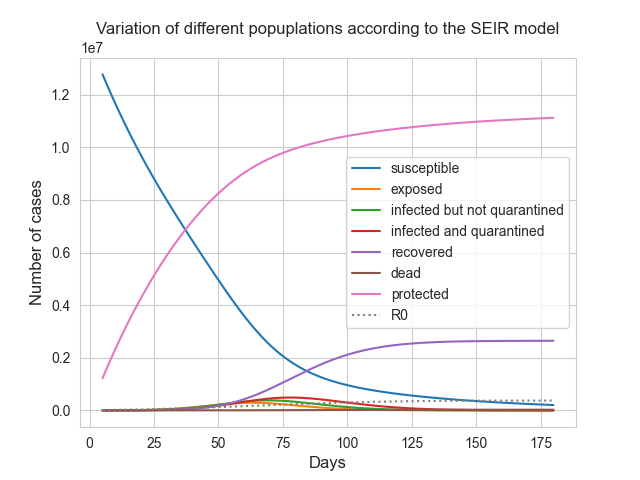

In [7]:
#Visualizing results
fig, ax = plt.subplots()
ax.plot(t[timespan], sol[0, timespan], label="susceptible")
ax.plot(t[timespan], sol[1, timespan], label="exposed")
ax.plot(t[timespan], sol[2, timespan], label="infected but not quarantined")
ax.plot(t[timespan], sol[3, timespan], label="infected and quarantined")
ax.plot(t[timespan], sol[4, timespan], label="recovered")
ax.plot(t[timespan], sol[5, timespan], label="dead")
ax.plot(t[timespan], sol[6, timespan], label="protected")
ax.plot(t[timespan], sol[7, timespan], label="R0", linestyle='dotted')

ax.legend()
ax.set_title("Variation of different popuplations according to the SEIR model")
ax.set_xlabel("Days", size=12)
ax.set_ylabel("Number of cases", size=12)

ax.legend()

plt.show()

# ------------------------------TODO se dai l'okay rimuovo proprio questa parte

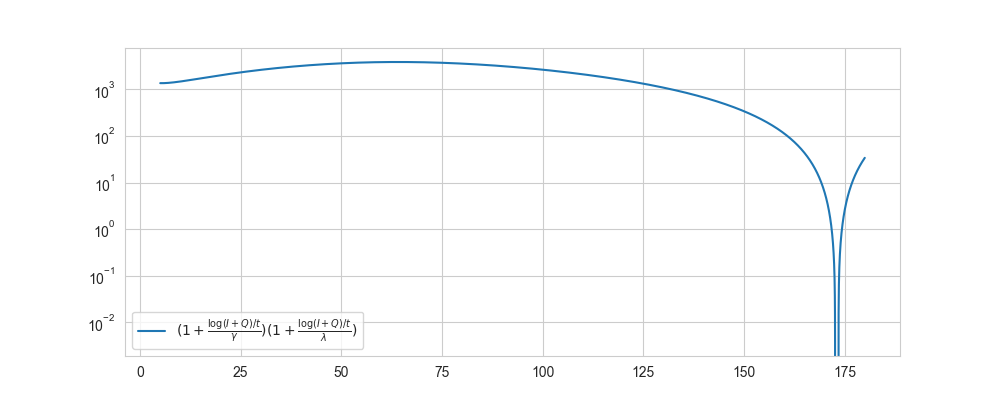

In [8]:
fig, ax = plt.subplots( figsize=(10,4))

I_t = sol[2, timespan]
tt = t[timespan]


R0 = (1 + np.log(I_t / tt) * gamma_inv) * (1 + np.log(I_t/ tt) / lam )

ax.plot(tt, R0, label=r"$(1+\frac{\log(I+Q)/t}{\gamma})(1+\frac{\log(I+Q)/t}{\lambda})$")
ax.set_yscale('log')


ax.legend()

plt.show()


### A focus on the infected cases 

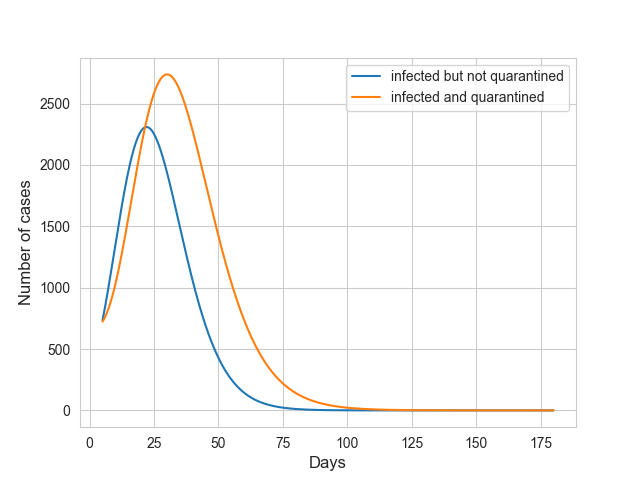

In [9]:
alpha2 = 0.083  # protection rate 
beta = 0.7      # infectious rate
gamma_inv = 5   # average incubation time
delta_inv = 7   # average quarantine time
lam = 0.1       # cure rate
kappa = 0.001   # mortality rate

sol2=solveSEIR(
    input_parameters=[alpha2, beta, gamma_inv, delta_inv, lam, kappa])

#Visualizing without recovered, susceptible and protected
fig, ax = plt.subplots()
ax.plot(t[timespan], sol2[2, timespan], label="infected but not quarantined")
ax.plot(t[timespan], sol2[3, timespan], label="infected and quarantined")

ax.legend()
ax.set_xlabel("Days", size=12)
ax.set_ylabel("Number of cases", size=12)

plt.show()

# Part 2: Sensitivity Analysis

#### Qualitative investigation

Visualizing the effect of varying the model parameters one-at-a-time within the range used in Ma2022 on the number of infected cases I

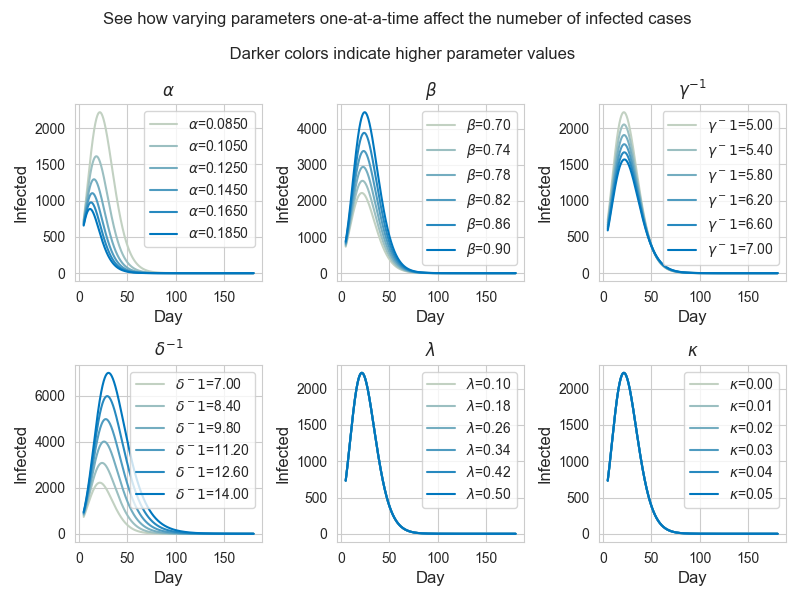

In [10]:
#fig, ax = plt.subplots()

n_values=6

NEWALPHA=0.085

#alpha_range=np.arange(0.085, 0.185, 0.04)
alpha_range=np.linspace(0.085, 0.185, n_values)

#beta_range=np.arange(0.5, 1.0, 0.1)
beta_range=np.linspace(0.7, 0.9, n_values)

#gamma_inv_range=np.arange(1/0.1, 1/0.35, 0.05)
gamma_inv_range=np.linspace(5, 7, n_values)

#delta_inv_range=np.arange(1/0.08, 1/0.18, 0.02)
delta_inv_range=np.linspace(7, 14, n_values)

lam_range=np.linspace(0.1, 0.5, n_values)
kappa_range=np.linspace(0.001, 0.05, n_values)

#Store maximum values of the infected
I_max_alpha=np.array(np.zeros(n_values))
I_max_beta=np.array(np.zeros(n_values))
I_max_gamma_inv=np.array(np.zeros(n_values))
I_max_delta_inv=np.array(np.zeros(n_values))
I_max_lam=np.array(np.zeros(n_values))
I_max_kappa=np.array(np.zeros(n_values))


#Creating colour list
import matplotlib.colors as colors
# Define the start and end colors
start_color = '#c2d1c2'   # pale green
end_color = '#0077be'  # blue

# Create a list of colors from stronger to weaker
num_colors = n_values
color_list = colors.hex2color(start_color)
color_list = [colors.to_hex(colors.LinearSegmentedColormap.from_list('', [color_list, colors.hex2color(end_color)], num_colors)(i)) for i in range(num_colors)]


#Plot
fig, ax = plt.subplots(2, 3, figsize=(8, 6))

# Total order
for i in range(len(alpha_range)):
    alpha_t=alpha_range[i]
    sol = solveSEIR(input_parameters=[alpha_t,beta,gamma_inv, delta_inv, kappa, lam])
    I_max_alpha[i]=np.max(sol[2,:])
    ax[0,0].plot(t[timespan], sol[2, timespan],label=rf"$\alpha$={alpha_t:.4f}",color=color_list[i])

for i in range(len(beta_range)):    
    beta_t=beta_range[i]
    sol = solveSEIR(input_parameters=[NEWALPHA,beta_t,gamma_inv, delta_inv, kappa, lam])
    ax[0,1].plot(t[timespan], sol[2, timespan],label=rf"$\beta$={beta_t:.2f}", color=color_list[i])
    I_max_beta[i]=np.max(sol[2,:])
    
for i in range(len(gamma_inv_range)):    
    gamma_inv_t=gamma_inv_range[i]
    sol = solveSEIR(input_parameters=[NEWALPHA,beta,gamma_inv_t, delta_inv, kappa, lam])
    ax[0,2].plot(t[timespan], sol[2, timespan],label=rf"$\gamma^{-1}$={gamma_inv_t:.2f}", color=color_list[i])
    I_max_gamma_inv[i]=np.max(sol[2,:])

for i in range(len(delta_inv_range)):    
    delta_inv_t=delta_inv_range[i]
  #  sol = solveSEIR(input_parameters=[0.125, 0.78, 1/0.2, delta_inv_t,  0.3, 0.025])
    sol = solveSEIR(input_parameters=[NEWALPHA,beta,gamma_inv, delta_inv_t, kappa, lam])
    ax[1,0].plot(t[timespan], sol[2, timespan],label=rf"$\delta^{-1}$={delta_inv_t:.2f}", color=color_list[i])
    I_max_delta_inv[i]=np.max(sol[2,:])
    
for i in range(len(lam_range)):        
    lambda_t=lam_range[i]
    sol = solveSEIR(input_parameters=[NEWALPHA, beta, gamma_inv, delta_inv, lambda_t, kappa])
    ax[1,1].plot(t[timespan], sol[2, timespan],label=rf"$\lambda$={lambda_t:.2f}", color=color_list[i])
    I_max_lam[i]=np.max(sol[2,:])
    
    kappa_t=kappa_range[i]
    sol = solveSEIR(input_parameters=[NEWALPHA, beta, gamma_inv, delta_inv, lam, kappa_t])
    ax[1,2].plot(t[timespan], sol[2, timespan],label=rf"$\kappa$={kappa_t:.2f}", color=color_list[i])
    I_max_kappa[i]=np.max(sol[2,:])


ax[0,0].set_title(r"$\alpha$")
ax[0,1].set_title(r"$\beta$")
ax[0,2].set_title(r"$\gamma^{-1}$")
ax[1,0].set_title(r"$\delta^{-1}$")
ax[1,1].set_title(r"$\lambda$")
ax[1,2].set_title(r"$\kappa$")

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel("Day", fontsize=12)
        ax[i,j].set_ylabel("Infected", fontsize=12)
        ax[i,j].legend()
    
fig.suptitle("See how varying parameters one-at-a-time affect the numeber of infected cases \n\n Darker colors indicate higher parameter values")
fig.tight_layout(pad=1.0)


plt.show()    


### Finding the maximum number of infected I 

In [11]:
print(I_max_alpha[0])

2217.5072415723102


### Finding the day of miximum number of infected I

In [12]:
index_array=np.where(sol[2,timespan]==np.max(sol[2,timespan]))
t[index_array][0]

16.615661566156618

#### Comments:
- With the following combination of parameters the maximum number of infected cases is reached around day 16
    - $\alpha$= 0.083   
    - $\beta$=  0.7 
    - $\gamma^{-1}$= 5
    - $\delta^{-1}$=7
    - $\lambda$= 0.1
    - $\kappa$= 0.01
- $\kappa$ and $\lambda$ do not seem to be influential on the output, whereas the other paraeters exert a higher influence
- As expected, lower valyes of $\alpha$ (protection rate) and $\gamma^{-1}$ (average quarantine time), lead to higher number of infected cases, whereas higher $\beta$ (average infectious rate) and $\gamma^{-1}$ (incubation time) heighten the number of infected cases

    

## We now move to the sensitivity analysis using UQpy

Import relevant modules and classes from `UQpy`.

In [13]:
from UQpy.run_model.RunModel import RunModel
from UQpy.run_model.model_execution.PythonModel import PythonModel
from UQpy.distributions import Uniform
from UQpy.distributions.collection.JointIndependent import JointIndependent
from UQpy.sensitivity.SobolSensitivity import SobolSensitivity
from UQpy.sensitivity.PostProcess import *

Create `PythonModel` object.

In [14]:
model = PythonModel(
    model_script="local_SEIR.py", # this file must be in the same folder
    model_object_name="solveSEIR_UQpy", # this is the name of the main function called in local_SEIR.py
    var_names=["alpha", # same order used when unpacking the parameters in solveSEIR
               "beta",
               "gamma_inv",
               "delta_inv",
               "lam",
               "kappa"
              ],
    delete_files=True
)

runmodel_obj = RunModel(model=model)

We set a uniform distribution as in the paper using `UQpy.distributions.Uniform`.

The `Uniform` distribution is based on `scipy` and receives `loc` and `scale`, so if
$$
U\sim U([a,b]) \qquad f_U(x;a,b) = \frac{1}{b-a}
$$
then
$$
a = loc \qquad b = loc + scale
$$
therefore
$$
loc = a \qquad scale = b - a
$$

In [15]:
A     = Uniform(0.085, (0.183 - 0.085 ))
B     = Uniform(0.7, (0.9 - 0.7))
G_inv = Uniform(5, (7 - 5 ))
D_inv = Uniform(7, (14 - 7))
L     = Uniform(0.1, (0.5 - 0.1 ))
K     = Uniform(0.001, (0.05 - 0.001 ))

dist_object = JointIndependent([A, B, G_inv, D_inv, L, K])

We create an object which contains the joint distribution of the paraeter of interest. Like in the paper, we choose a joint independent distribution using `UQpy.distributions.collection.JointIndependent`

Perform the sensitivity analysis (including second-order Sobol indexes) and measure the time taken by the cell to execute it.

In [16]:
%%time
SA = SobolSensitivity(runmodel_obj, dist_object)
SA.run(n_samples=2000, estimate_second_order=True, first_order_scheme='Sobol1993')

CPU times: user 2min 36s, sys: 18.8 s, total: 2min 55s
Wall time: 3min 13s


Investigate the shape of the resulting quantities.

In [17]:
np.shape(SA.first_order_indices)

(6, 10000)

In [18]:
np.shape(SA.total_order_indices)

(6, 10000)

In [19]:
np.shape(SA.second_order_indices)

(15, 10000)

Plot the first order indexes in 3D.

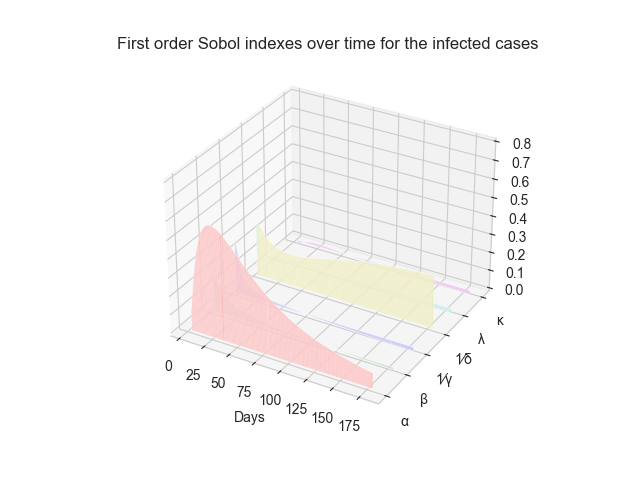

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

c = ['r', 'g', 'b', 'y', 'c', 'm']

# Unicode names for z = ['alpha', 'beta', 'gamma_inv', 'delta_inv', 'lambda', 'kappa']

z = ['\u03b1', '\u03B2', "1"+"\u2044" + "\u03B3", '1'+'\u2044' +'\u03B4' , '\u03BB', '\u03BA']
z_inv = [   '\u03BA' ,  '\u03BB', '1'+'\u2044' +'\u03B4', "1"+"\u2044" + "\u03B3", '\u03B2','\u03b1']

# Dictionary associating the parameter (unicode) names with values, so that they will appear directly in the plot
y_values = {'\u03b1': 0, '\u03B2': 1, "1"+"\u2044" + "\u03B3": 2, '1'+'\u2044' +'\u03B4': 3, '\u03BB': 4, '\u03BA': 5}
y_values_inv = {'\u03b1': 5, '\u03B2': 4, "1"+"\u2044" + "\u03B3": 3, '1'+'\u2044' +'\u03B4': 1, '\u03BB': 1, '\u03BA': 0}

for i in range(np.shape(SA.first_order_indices.T[1:])[1]):
    xs = t[timespan]
    ys = SA.first_order_indices[i, timespan]

    # subsample every 100
    xs = xs[::30]
    ys = ys[::30]

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c[i]] * len(xs)
    cs[0] = 'c'
    #ax.bar(xs, height=ys, zs=y_values[z_inv[i]], zdir='y', color=cs, alpha=0.3)
    ax.bar(xs, height=ys, zs=y_values[z[i]], zdir='y', color=cs, alpha=0.3)

ax.set_xlabel('Days')
#ax.set_ylabel('Y')
#ax.set_zlabel('First order Sobol')
ax.set_zlim(0,0.8)
ax.set_yticks(range(len(y_values)))
ax.set_yticklabels(z)

ax.set_title("First order Sobol indexes over time for the infected cases")

plt.show()


### Plotting first order and total order Sobol indices in time in 2-D

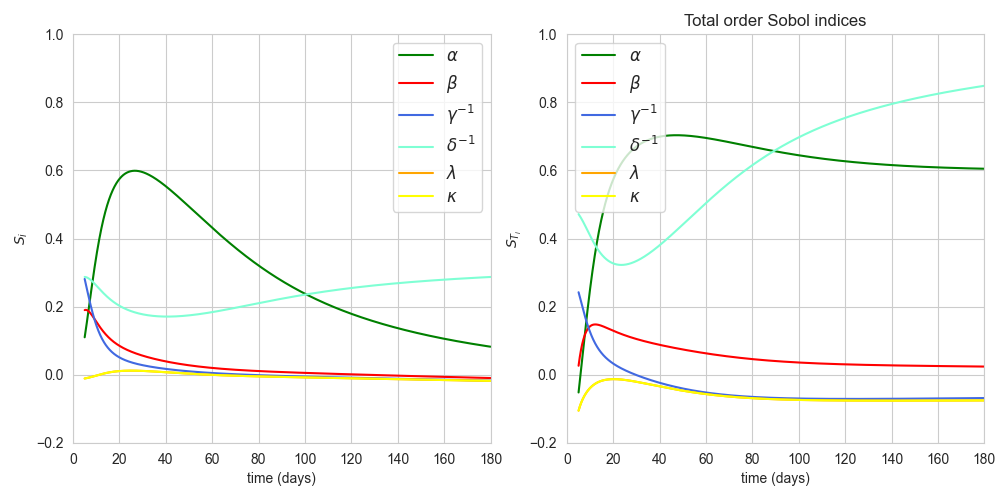

In [33]:
#fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Total order
ax[1].plot(t[timespan], SA.total_order_indices[0, timespan], "g",label=r"$\alpha$")
ax[1].plot(t[timespan], SA.total_order_indices[1, timespan], "r" ,label=r"$\beta$")
ax[1].plot(t[timespan], SA.total_order_indices[2, timespan], label=r"$\gamma^{-1}$", color="royalblue")
ax[1].plot(t[timespan], SA.total_order_indices[3, timespan], label=r"$\delta^{-1}$", color="aquamarine")
ax[1].plot(t[timespan], SA.total_order_indices[4, timespan], label=r"$\lambda$", color="orange")
ax[1].plot(t[timespan], SA.total_order_indices[5, timespan], label=r"$\kappa$", color="yellow")

ax[1].set_title("Total order Sobol indices")
ax[1].set_xlabel("time (days)")
ax[1].set_ylabel(r"$S_{T_i}$")
ax[1].set_xbound(0, t[-1])
ax[1].set_ybound(-0.2, 1)
ax[1].legend(fontsize=12)

#fiirst order
ax[0].plot(t[timespan], SA.first_order_indices[0, timespan], "g",label=r"$\alpha$")
ax[0].plot(t[timespan], SA.first_order_indices[1, timespan], "r" ,label=r"$\beta$")
ax[0].plot(t[timespan], SA.first_order_indices[2, timespan], label=r"$\gamma^{-1}$", color="royalblue")
ax[0].plot(t[timespan], SA.first_order_indices[3, timespan], label=r"$\delta^{-1}$", color="aquamarine")
ax[0].plot(t[timespan], SA.first_order_indices[4, timespan], label=r"$\lambda$", color="orange")
ax[0].plot(t[timespan], SA.first_order_indices[5, timespan], label=r"$\kappa$", color="yellow")

#ax[0].set_title("First order Sobol indices")
ax[0].set_xlabel("time (days)")
ax[0].set_ylabel(r"$S_i$")
ax[0].set_xbound(0, t[-1])
ax[0].set_ybound(-0.2, 1)
ax[0].legend(fontsize=12)

#fig.suptitle("Pointwise-in-time Sobol indices for infected cases")
fig.tight_layout(pad=1.0)

plt.show()

Computing the maximu value of alpha and the corresponding day

In [34]:
print("max is ",np.max(SA.first_order_indices[0, timespan]))
print("day is", int(np.ceil(t[np.where(SA.first_order_indices[0,:]==np.max(SA.first_order_indices[0, timespan]))]) ))

max is  0.5990437031303
day is 27


### Comments

- The time dynamics of the first-order Sobol index for each parameter fully reproduces the results from the paper (**Fig. 5**)
- The parameter $\alpha$, modelling the protection rate, is the most highli influential for the number of infected cases, reaching its maximum influence around day 27-30, with the Sobol index value of around 0.60
- The average quarantine time $\delta^{-1}$ also seems to be influential on the infected cases, with a trend that is opposite to the one of $\alpha$, but never reaching its values

### Trying to reproduce the Uncertainty Quantification on alpha with cool bands

Varying the protection rate $\alpha$ and taking the pointwise confidence bands as

$$mean\pm z_{1-\alpha/2} \cdot std$$


In [35]:
alpha_space = np.linspace(0.085, 0.183, 1000)

out = np.zeros((1000, 10000))

for index, alpha_i in enumerate(alpha_space):
    soluz = solveSEIR(input_parameters=[alpha_i, beta, gamma_inv, delta_inv, lam, kappa])
    out[index, :] = soluz[2]

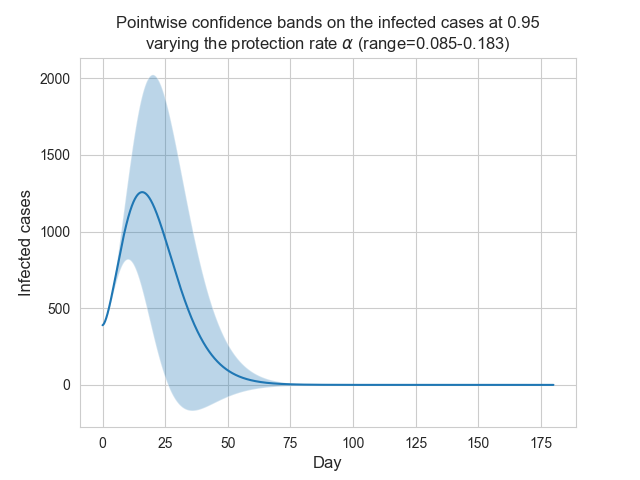

In [36]:
import scipy
mean = np.mean(out, axis=0)
std = np.std(out, axis=0)
alpha = 0.05 
lower=0.085
upper=0.183
z = scipy.stats.norm.ppf(1-alpha/2)


fig, ax = plt.subplots()
ax.plot(t, mean)
ax.set_xlabel("Day", size=12)
ax.set_ylabel("Infected cases", size=12)
ax.set_title(f"Pointwise confidence bands on the infected cases at {1 - alpha}\n"
             f"varying the protection rate $\\alpha$ (range={lower}-{upper})")
ax.fill_between(t, mean-std*z, mean+std*z, alpha=0.3)

plt.show()

## Factor prioritization based on the first order Sobol index

Approaches to have a single index over the whole timespan 
1. Compute the mean over time
2. Rudimental approach : integrating the value of the Sobol index over time **---------------------- TODO VEDERE SE LEVARE**

### Computing the mean of first-order Sobol index over time

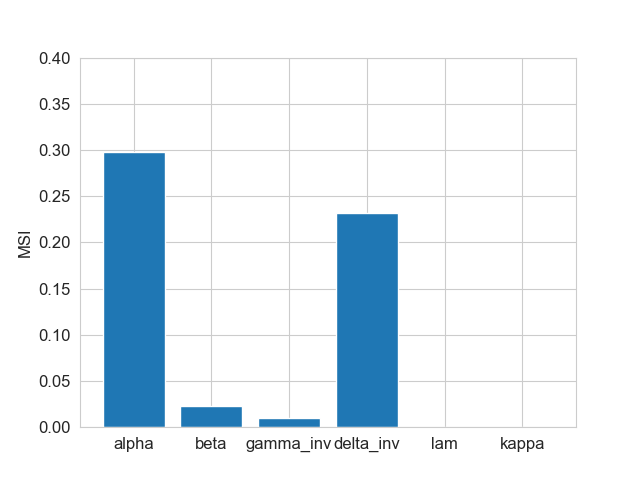

In [55]:
#Approach 1: mean over time

#Number of parameters
n_parameters=6

first_order_sobol_mean=np.zeros(n_parameters)
for i in range(n_parameters):
    first_order_sobol_mean[i]=np.mean(SA.first_order_indices[i, timespan])

var_names=["alpha",
           "beta",
           "gamma_inv",
           "delta_inv",
           "lam",
           "kappa"]

plt.clf()
plt.bar(var_names, first_order_sobol_mean)
plt.ylim(0,0.4)
plt.rcParams['font.size'] = 6

plt.ylabel('MSI')
#plt.title('Mean of first order Sobol index on infected people')
plt.show()

### Computing the integral of first-order Sobol index over time

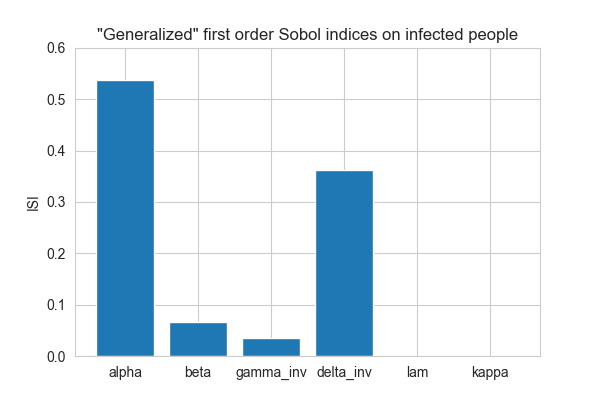

In [98]:
from scipy.integrate import cumulative_trapezoid

sobol_first = SA.first_order_indices[:, timespan]
# Set to zero negative elements
sobol_first[sobol_first < 0] = 0

x = t[timespan]

num_inputs = np.shape(SA.first_order_indices)[0]

# Initialize output vector
first_s_int = np.zeros(num_inputs)

# Compute strange integral
for i in range(num_inputs):
    y = sobol_first[i, :]
    result = cumulative_trapezoid(y, x)
    first_s_int[i] = sum(result)

# Normalize with the sum of all
first_s_int = first_s_int / np.sum(first_s_int)

var_names=["alpha",
           "beta",
           "gamma_inv",
           "delta_inv",
           "lam",
           "kappa"]

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(var_names, first_s_int)
ax.set_ylim(0,0.6)
ax.set_ylabel('ISI')
ax.set_title('"Generalized" first order Sobol indices on infected people')
plt.show()

### Reproducing the work from Ma2022, Sobol index at t = 90

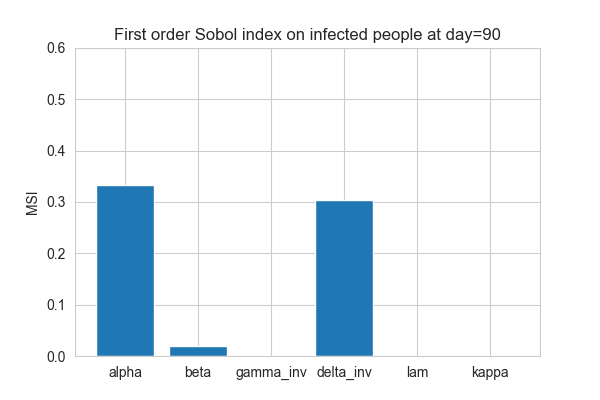

In [99]:
fig, ax = plt.subplots(figsize=(6,4))

#Extracting the timing of the 90th day (the first value of t >=90)
index=np.where(t>=90)[0][0]

#Computing the first order Sobol index
first_order_sobol_day90=SA.first_order_indices[:, index]

var_names=["alpha",
           "beta",
           "gamma_inv",
           "delta_inv",
           "lam",
           "kappa"]

ax.bar(var_names, first_order_sobol_day90)

ax.set_ylim(0,0.6)
ax.set_ylabel('MSI')
ax.set_title('First order Sobol index on infected people at day=90')
plt.show()

### Assessing second order interactions 

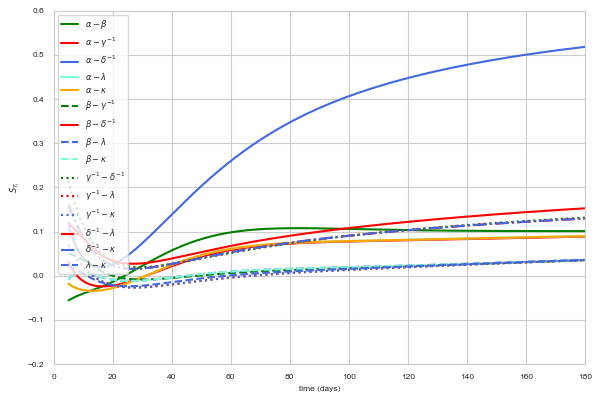

In [60]:
fig, ax = plt.subplots(figsize=(6,4))

# Alpha
ax.plot(t[timespan], SA.second_order_indices[0, timespan], "g",label=r"$\alpha-\beta$")
ax.plot(t[timespan], SA.second_order_indices[1, timespan], "r" ,label=r"$\alpha-\gamma^{-1}$")
ax.plot(t[timespan], SA.second_order_indices[2, timespan], label=r"$\alpha-\delta^{-1}$", color="royalblue")
ax.plot(t[timespan], SA.second_order_indices[3, timespan], label=r"$\alpha-\lambda$", color="aquamarine")
ax.plot(t[timespan], SA.second_order_indices[4, timespan], label=r"$\alpha-\kappa$", color="orange")

ax.plot(t[timespan], SA.second_order_indices[5, timespan], "g",label=r"$\beta-\gamma^{-1}$", linestyle='dashed')
ax.plot(t[timespan], SA.second_order_indices[6, timespan], "r" ,label=r"$\beta-\delta^{-1}$")
ax.plot(t[timespan], SA.second_order_indices[7, timespan], label=r"$\beta-\lambda$", color="royalblue", linestyle='dashed')
ax.plot(t[timespan], SA.second_order_indices[8, timespan], label=r"$\beta-\kappa$", color="aquamarine", linestyle='dashed')

ax.plot(t[timespan], SA.second_order_indices[9, timespan], "g",label=r"$\gamma^{-1}-\delta^{-1}$", linestyle='dotted')
ax.plot(t[timespan], SA.second_order_indices[10, timespan], "r" ,label=r"$\gamma^{-1}-\lambda$", linestyle='dotted')
ax.plot(t[timespan], SA.second_order_indices[11, timespan], label=r"$\gamma^{-1}-\kappa$", color="royalblue", linestyle='dotted')

ax.plot(t[timespan], SA.second_order_indices[12, timespan], "r" ,label=r"$\delta^{-1}-\lambda$", linestyle='dashdot')
ax.plot(t[timespan], SA.second_order_indices[13, timespan], label=r"$\delta^{-1}-\kappa$", color="royalblue", linestyle='dashdot')
ax.plot(t[timespan], SA.second_order_indices[14, timespan], label=r"$\lambda-\kappa$", color="royalblue", linestyle='dashed')

#ax.set_title("Second order Sobol indices")
ax.set_xlabel("time (days)")
ax.set_ylabel(r"$S_{T_i}$")
ax.set_xbound(0, t[-1])
ax.set_ybound(-0.2, 0.6)
ax.legend()

#fig.suptitle("Pointwise-in-time Sobol indices for Infected people")
fig.tight_layout(pad=1.0)

plt.show()

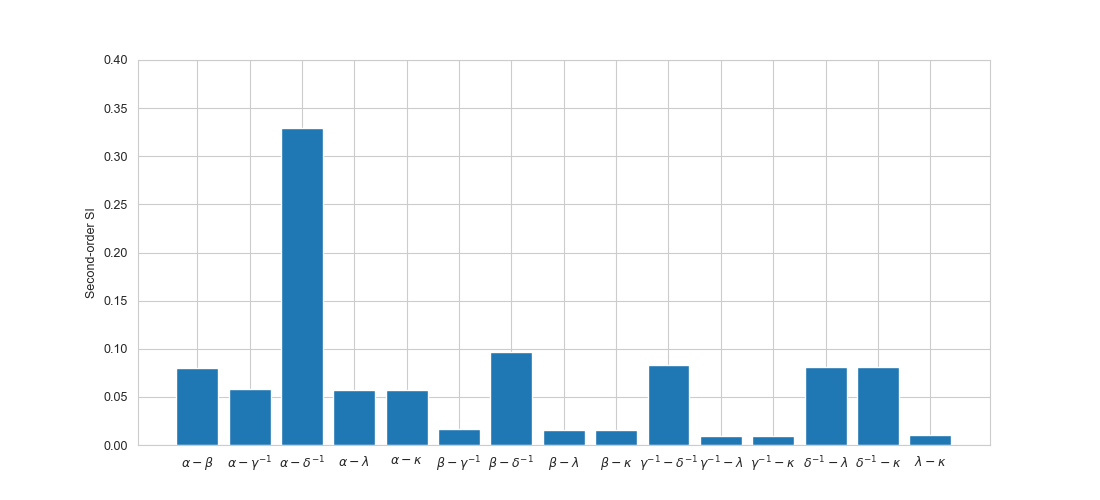

In [69]:
#Mean over time of the second order interactions
fig, ax = plt.subplots(figsize=(11,5))

#Number of parameters
n_secondorder=15

second_order_sobol_mean=np.zeros(n_secondorder)
for i in range(n_secondorder):
    second_order_sobol_mean[i]=np.mean(SA.second_order_indices[i, timespan])

var_interaction_names=[r"$\alpha-\beta$",
           r"$\alpha-\gamma^{-1}$",
           r"$\alpha-\delta^{-1}$",
           r"$\alpha-\lambda$",
           r"$\alpha-\kappa$",
           r"$\beta-\gamma^{-1}$",
           r"$\beta-\delta^{-1}$",
           r"$\beta-\lambda$",
           r"$\beta-\kappa$",
           r"$\gamma^{-1}-\delta^{-1}$",
           r"$\gamma^{-1}-\lambda$",
           r"$\gamma^{-1}-\kappa$",
           r"$\delta^{-1}-\lambda$",
           r"$\delta^{-1}-\kappa$",
           r"$\lambda-\kappa$"]

ax.bar(var_interaction_names, second_order_sobol_mean)
plt.rcParams['font.size'] = 9

ax.set_ylim(0,0.4)
ax.set_ylabel('Second-order SI')
#ax.set_title('Mean over time of the second order Sobol index on infected people')
plt.show()

#### Comments

- The most influential interaction is between the protection rate $\alpha$ and the average quarantine time $\delta^{-1}$, which steadily increases fro day 30 and remains high until day 180
- The other interactions are trascurable

# LAST STEPS

- Specificare i metodi di calcolo dei Sobol

- Anticipate possible questions (conceptual and practical)

- Domande esistenziale: infettati non quarantenati, come fanno a esistere se uno che scopre di essere infettato viene immediatamente quarantenato